# 1.  Bias-variance tradeoff.

## a) (1pt) normalize the entire data set 

In [370]:
import numpy as np
import pickle
import pandas as pd
from torch import nn
import torch
import matplotlib.pyplot as plt


X_train: (60000, 32, 32)
Y_train: (60000,)
X_test:  (10000, 32, 32)
Y_test:  (10000,)


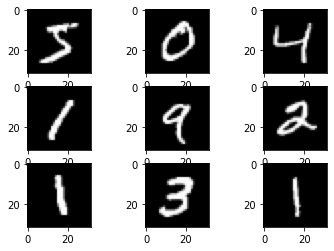

In [371]:
import pickle
(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
 
#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for i in range(9):  
    plt.subplot(3,3,i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

In [372]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [373]:
for i in range(60000):
    if np.amax(train_X[i]) != 0:
        train_X[i] = train_X[i]/np.amax(train_X[i])

for i in range(10000):
    if np.amax(test_X[i]) != 0:
        test_X[i] = test_X[i]/np.amax(test_X[i])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26666668,
       0.8745098 , 0.9882353 , 0.9882353 , 0.9882353 , 0.9882353 ,
       0.9882353 , 0.15294118, 0.07450981, 0.15294118, 0.25490198,
       0.8784314 , 0.9882353 , 0.9882353 , 0.7176471 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

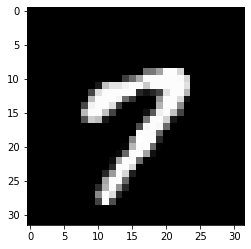

In [374]:
plt.imshow(train_X[15], cmap=plt.get_cmap('gray'))
train_X[15][12]

### (b) (2pt) The data folder you are given is already organized into a training set and a test set. Therefore, to create a validation set, divide the original training  data  into  3-fold  groups  of  training  (2/3  of  the  training  data), validation  (1/3  of  the  training  data). 

In [375]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [376]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop,l2,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float))
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)

        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    lambda_val = 0.00001
                    change = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss += lambda_val*change
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().cpu().item() * batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
                epoch_acc += acc.detach().cpu().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        if torch.is_tensor(inputs):
            inputs = self.input_transform(inputs)
        else:
            inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float))
            outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            # compute accuracy of classification 
            batch_acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == batch_output) / len(batch_predictions)
            losses += loss.detach().cpu().item() * batch_importance
            acc += batch_acc.detach().cpu().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [377]:
from sklearn.model_selection import train_test_split,KFold
def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs=50,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,1024)):
    """ Do Kfold cross validation with the specified arguments
    model_func: function. 
        Constructor of the model.
    k: int. The number of fold
    Xs: np.array, The shape of Xs.reshape(input_shape) should be (ndata,nfeatures)
    ys: np.array shape (ndata,)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be (ndata,nfeatures)
    test_ys: np.array shape (ndata,)
    epoch: int
    batch_size: int
    early_stop: bool
    lr: float. learning_rate
    l2: bool
    optimizer: 'adam' or 'sgd'
    input_shape: tuple
    """
    
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    fold=0
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        # Decide training examples and validation examples for this fold
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        
        model=model_func()
        ### Use the trainer class to train the model ###
        trainer = Trainer(model,optimizer,lr,epochs,batchsize,input_transform=lambda x: x) ###### what I think might be correct
        log=trainer.train(train_Xs,train_ys,val_Xs,val_ys,early_stop,l2) ####
        
        if draw_curve:
            plt.figure()
            plt.plot(log["losses"], label="losses")
            plt.plot(log["val_losses"], label="validation_losses")
            plt.legend()
            plt.title(f'Fold #{fold} loss')

            plt.figure()
            plt.plot(log["accuracies"], label="accuracies")
            plt.plot(log["val_accuracies"], label="validation_accuracies")
            plt.legend()
            plt.title(f'Fold #{fold} accuracy')
        
        # Report result for this fold
        if early_stop:
            report_idx= np.argmin(log["val_losses"])      
        else:
            report_idx=-1
        test_acc=trainer.evaluate(test_Xs,test_ys,print_acc=False)[1]
        train_acc_all.append(log["accuracies"][report_idx])
        test_acc_all.append(test_acc)
        print("Train accuracy:",log["accuracies"][report_idx])
        print("Validation accuracy:",log["val_accuracies"][report_idx])
        print("Test accuracy:",test_acc)
        
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

### (c) (3pt) Devise an ANN that has 2 computing layers: a hidden layer of size 3 neurons and the final output layer of 10 output neurons 

In [378]:
train_X = train_X.reshape(60000,1024)
test_X = test_X.reshape(10000,1024)

In [379]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024,3),
            nn.Sigmoid(),
            nn.Linear(3,10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.layers(x)

Fold #1


  2%|▏         | 1/50 [00:00<00:20,  2.37it/s]

Epoch 1/50 - Loss: 2.240 - Acc: 0.264
              Val_loss: 2.186 - Val_acc: 0.423


 22%|██▏       | 11/50 [00:02<00:09,  3.91it/s]

Epoch 11/50 - Loss: 1.844 - Acc: 0.638
              Val_loss: 1.844 - Val_acc: 0.636


 42%|████▏     | 21/50 [00:05<00:07,  3.95it/s]

Epoch 21/50 - Loss: 1.797 - Acc: 0.681
              Val_loss: 1.799 - Val_acc: 0.680


 62%|██████▏   | 31/50 [00:07<00:04,  4.04it/s]

Epoch 31/50 - Loss: 1.752 - Acc: 0.742
              Val_loss: 1.759 - Val_acc: 0.734


 82%|████████▏ | 41/50 [00:10<00:02,  3.95it/s]

Epoch 41/50 - Loss: 1.730 - Acc: 0.759
              Val_loss: 1.740 - Val_acc: 0.744


func:'train'  took: 13.1728 sec
Train accuracy: 0.7664249999999998
Validation accuracy: 0.7488000000000007
Test accuracy: 0.7601000000000001
Fold #2


  2%|▏         | 1/50 [00:00<00:17,  2.75it/s]

Epoch 1/50 - Loss: 2.250 - Acc: 0.262
              Val_loss: 2.199 - Val_acc: 0.302


 22%|██▏       | 11/50 [00:03<00:09,  3.90it/s]

Epoch 11/50 - Loss: 1.847 - Acc: 0.635
              Val_loss: 1.849 - Val_acc: 0.628


 42%|████▏     | 21/50 [00:05<00:07,  3.99it/s]

Epoch 21/50 - Loss: 1.800 - Acc: 0.686
              Val_loss: 1.808 - Val_acc: 0.672


 62%|██████▏   | 31/50 [00:08<00:04,  3.93it/s]

Epoch 31/50 - Loss: 1.781 - Acc: 0.699
              Val_loss: 1.794 - Val_acc: 0.682


 82%|████████▏ | 41/50 [00:10<00:02,  3.92it/s]

Epoch 41/50 - Loss: 1.771 - Acc: 0.704
              Val_loss: 1.787 - Val_acc: 0.684


func:'train'  took: 13.1695 sec
Train accuracy: 0.707875
Validation accuracy: 0.68795
Test accuracy: 0.6855000000000001
Fold #3


  2%|▏         | 1/50 [00:00<00:15,  3.14it/s]

Epoch 1/50 - Loss: 2.233 - Acc: 0.322
              Val_loss: 2.169 - Val_acc: 0.359


 22%|██▏       | 11/50 [00:02<00:10,  3.69it/s]

Epoch 11/50 - Loss: 1.965 - Acc: 0.495
              Val_loss: 1.970 - Val_acc: 0.490


 42%|████▏     | 21/50 [00:05<00:07,  3.69it/s]

Epoch 21/50 - Loss: 1.882 - Acc: 0.605
              Val_loss: 1.873 - Val_acc: 0.616


 62%|██████▏   | 31/50 [00:08<00:05,  3.69it/s]

Epoch 31/50 - Loss: 1.748 - Acc: 0.760
              Val_loss: 1.753 - Val_acc: 0.753


 82%|████████▏ | 41/50 [00:11<00:02,  3.73it/s]

Epoch 41/50 - Loss: 1.717 - Acc: 0.776
              Val_loss: 1.724 - Val_acc: 0.766


func:'train'  took: 14.0005 sec
Train accuracy: 0.7815249999999997
Validation accuracy: 0.7697500000000003
Test accuracy: 0.7714999999999997
Final results:
Training accuracy:0.751942+-0.031764
Testing accuracy:0.739033+-0.038139


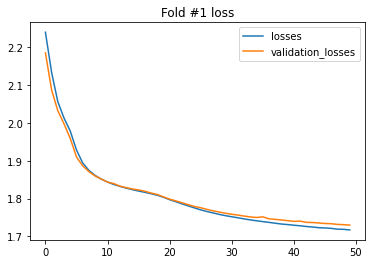

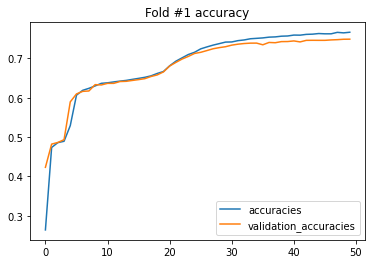

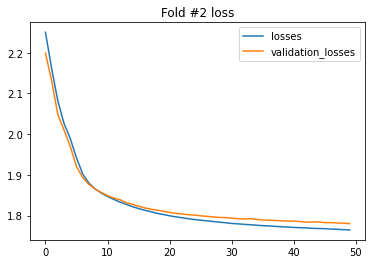

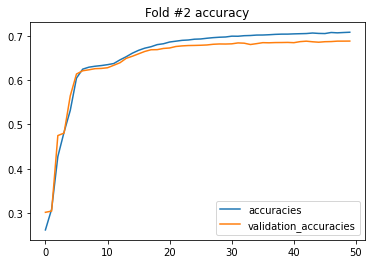

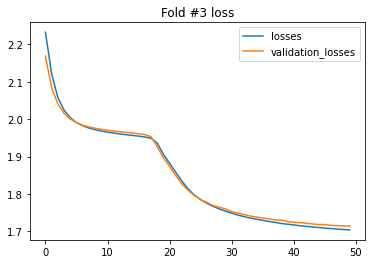

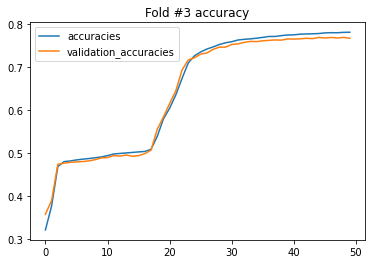

In [380]:
beast = Kfold(MLP,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,1024))

### answer: The capacity of the model is not that great (there is a bit of underfitting due to high bias/small variance) as the curves are exhibiting a slow decrease in both validation and training loss and the final losses are not as low as they are in subsequent questions, which results in good but not great accuracies of around 70%.

### (d) (3pt)  Devise another ANN with hidden layer of size 50. Do the same as in (1c). 

In [381]:
class MLPx(nn.Module):
    def __init__(self):
        super(MLPx, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024,50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.layers(x)

Fold #1


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

Epoch 1/50 - Loss: 1.832 - Acc: 0.710
              Val_loss: 1.645 - Val_acc: 0.854


 22%|██▏       | 11/50 [00:06<00:23,  1.64it/s]

Epoch 11/50 - Loss: 1.503 - Acc: 0.966
              Val_loss: 1.516 - Val_acc: 0.952


 42%|████▏     | 21/50 [00:13<00:17,  1.65it/s]

Epoch 21/50 - Loss: 1.486 - Acc: 0.980
              Val_loss: 1.506 - Val_acc: 0.959


 62%|██████▏   | 31/50 [00:19<00:12,  1.57it/s]

Epoch 31/50 - Loss: 1.478 - Acc: 0.986
              Val_loss: 1.504 - Val_acc: 0.961


 82%|████████▏ | 41/50 [00:25<00:05,  1.67it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.989
              Val_loss: 1.502 - Val_acc: 0.962


func:'train'  took: 31.6096 sec
Train accuracy: 0.9904000000000006
Validation accuracy: 0.9624999999999988
Test accuracy: 0.9637000000000007
Fold #2


  2%|▏         | 1/50 [00:00<00:32,  1.51it/s]

Epoch 1/50 - Loss: 1.847 - Acc: 0.686
              Val_loss: 1.665 - Val_acc: 0.826


 22%|██▏       | 11/50 [00:06<00:23,  1.66it/s]

Epoch 11/50 - Loss: 1.505 - Acc: 0.964
              Val_loss: 1.516 - Val_acc: 0.952


 42%|████▏     | 21/50 [00:13<00:17,  1.61it/s]

Epoch 21/50 - Loss: 1.488 - Acc: 0.979
              Val_loss: 1.508 - Val_acc: 0.957


 62%|██████▏   | 31/50 [00:19<00:12,  1.51it/s]

Epoch 31/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.504 - Val_acc: 0.960


 82%|████████▏ | 41/50 [00:25<00:05,  1.63it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.989
              Val_loss: 1.502 - Val_acc: 0.960


func:'train'  took: 31.2983 sec
Train accuracy: 0.9900000000000008
Validation accuracy: 0.9613499999999989
Test accuracy: 0.9646000000000003
Fold #3


  2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

Epoch 1/50 - Loss: 1.849 - Acc: 0.697
              Val_loss: 1.636 - Val_acc: 0.889


 22%|██▏       | 11/50 [00:06<00:23,  1.67it/s]

Epoch 11/50 - Loss: 1.505 - Acc: 0.964
              Val_loss: 1.519 - Val_acc: 0.949


 42%|████▏     | 21/50 [00:12<00:17,  1.69it/s]

Epoch 21/50 - Loss: 1.487 - Acc: 0.979
              Val_loss: 1.509 - Val_acc: 0.956


 62%|██████▏   | 31/50 [00:19<00:11,  1.61it/s]

Epoch 31/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.505 - Val_acc: 0.959


 82%|████████▏ | 41/50 [00:25<00:05,  1.67it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.988
              Val_loss: 1.503 - Val_acc: 0.960


func:'train'  took: 30.7177 sec
Train accuracy: 0.9899750000000009
Validation accuracy: 0.9611999999999988
Test accuracy: 0.9627000000000004
Final results:
Training accuracy:0.990125+-0.000195
Testing accuracy:0.963667+-0.000776


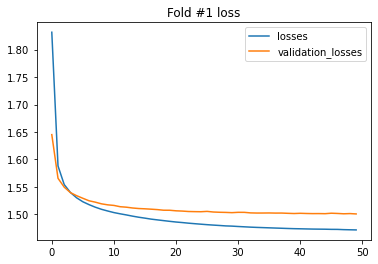

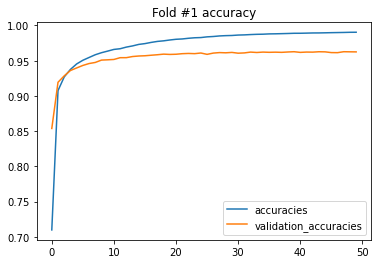

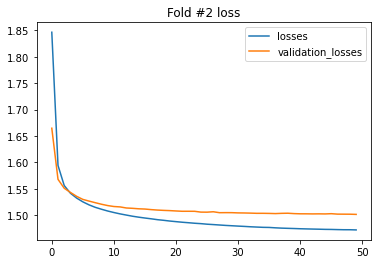

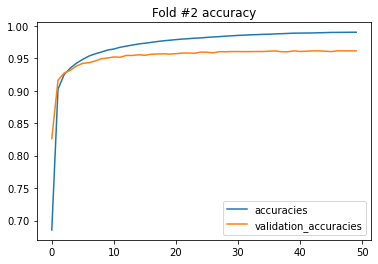

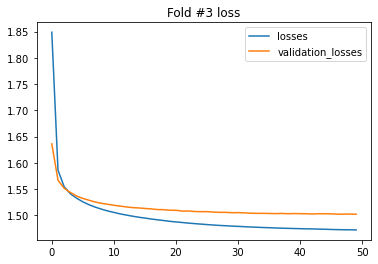

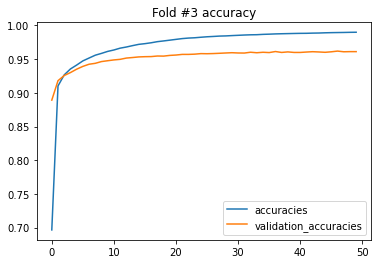

In [382]:
beastx = Kfold(MLPx,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,1024))

### answer: The model has too high of a capacity and is overfitting the data (high variance/low bias) as although the accuracy of the test data is 96%, the training accuracy of 99% and the growing gap between the validation and training loss on the curves means the model is overfitting and is not generalizing perfectly enough to unseen data.

# Q2.  Deep Learning and regularization. (11pt)

### (a) (3pt) Using the ANN from 1(d), utilize dropout with 15%.

In [383]:
class MLPd(nn.Module):
    def __init__(self):
        super(MLPd, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024,50),
            nn.Dropout(p=0.15),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.layers(x)

Fold #1


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch 1/50 - Loss: 1.867 - Acc: 0.682
              Val_loss: 1.658 - Val_acc: 0.832


 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

Epoch 11/50 - Loss: 1.517 - Acc: 0.954
              Val_loss: 1.520 - Val_acc: 0.946


 42%|████▏     | 21/50 [00:14<00:18,  1.54it/s]

Epoch 21/50 - Loss: 1.501 - Acc: 0.966
              Val_loss: 1.512 - Val_acc: 0.952


 62%|██████▏   | 31/50 [00:20<00:12,  1.56it/s]

Epoch 31/50 - Loss: 1.494 - Acc: 0.972
              Val_loss: 1.508 - Val_acc: 0.955


 82%|████████▏ | 41/50 [00:26<00:05,  1.58it/s]

Epoch 41/50 - Loss: 1.489 - Acc: 0.976
              Val_loss: 1.506 - Val_acc: 0.956


func:'train'  took: 32.3413 sec
Train accuracy: 0.9778500000000011
Validation accuracy: 0.9563999999999993
Test accuracy: 0.9578
Fold #2


  2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

Epoch 1/50 - Loss: 1.863 - Acc: 0.701
              Val_loss: 1.659 - Val_acc: 0.832


 22%|██▏       | 11/50 [00:06<00:23,  1.63it/s]

Epoch 11/50 - Loss: 1.518 - Acc: 0.952
              Val_loss: 1.524 - Val_acc: 0.942


 42%|████▏     | 21/50 [00:13<00:22,  1.28it/s]

Epoch 21/50 - Loss: 1.503 - Acc: 0.964
              Val_loss: 1.516 - Val_acc: 0.948


 62%|██████▏   | 31/50 [00:20<00:13,  1.44it/s]

Epoch 31/50 - Loss: 1.496 - Acc: 0.970
              Val_loss: 1.511 - Val_acc: 0.952


 82%|████████▏ | 41/50 [00:27<00:05,  1.53it/s]

Epoch 41/50 - Loss: 1.492 - Acc: 0.973
              Val_loss: 1.509 - Val_acc: 0.954


func:'train'  took: 33.6158 sec
Train accuracy: 0.9753500000000009
Validation accuracy: 0.9545999999999993
Test accuracy: 0.9549000000000004
Fold #3


  2%|▏         | 1/50 [00:00<00:38,  1.26it/s]

Epoch 1/50 - Loss: 1.885 - Acc: 0.656
              Val_loss: 1.672 - Val_acc: 0.823


 22%|██▏       | 11/50 [00:07<00:25,  1.56it/s]

Epoch 11/50 - Loss: 1.517 - Acc: 0.954
              Val_loss: 1.521 - Val_acc: 0.945


 42%|████▏     | 21/50 [00:13<00:18,  1.54it/s]

Epoch 21/50 - Loss: 1.501 - Acc: 0.966
              Val_loss: 1.510 - Val_acc: 0.953


 62%|██████▏   | 31/50 [00:20<00:12,  1.51it/s]

Epoch 31/50 - Loss: 1.494 - Acc: 0.972
              Val_loss: 1.507 - Val_acc: 0.955


 82%|████████▏ | 41/50 [00:27<00:06,  1.48it/s]

Epoch 41/50 - Loss: 1.490 - Acc: 0.976
              Val_loss: 1.506 - Val_acc: 0.957


func:'train'  took: 33.3240 sec
Train accuracy: 0.9765250000000015
Validation accuracy: 0.9581499999999992
Test accuracy: 0.9588000000000008
Final results:
Training accuracy:0.976575+-0.001021
Testing accuracy:0.957167+-0.001654


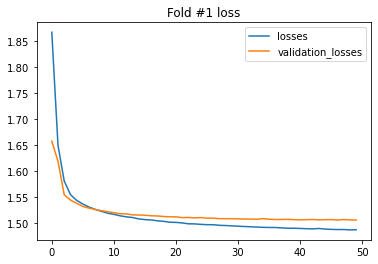

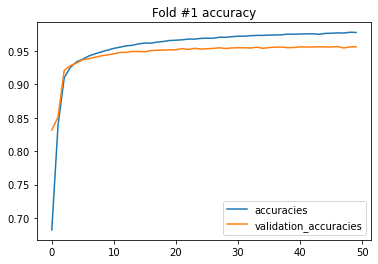

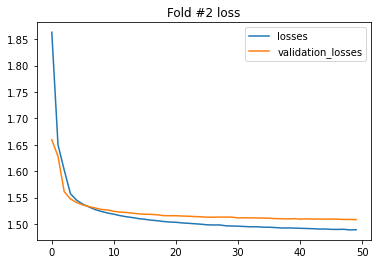

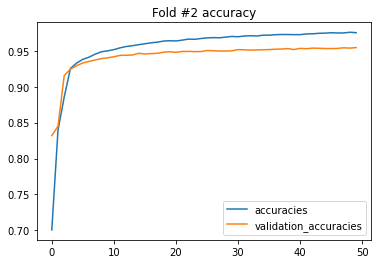

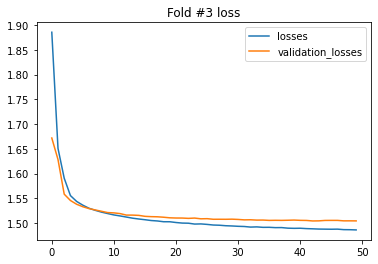

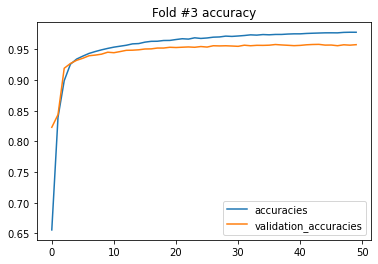

In [384]:
beastd = Kfold(MLPd,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,1024))

### Answer: There seems to be less overfitting (still a bit left) as the gap between the validation and training loss is not as extensive in the curves as it was without dropout.

### Without dropout:
### Training accuracy:0.990125+-0.000195
### Testing accuracy:0.963667+-0.000776

### With dropout:
### Training accuracy:0.976575+-0.001021
### Testing accuracy:0.957167+-0.001654

### Both training and testing accuracies decreased with dropout by a bit, but the gap between accuracies with dropout is smaller than it is when using dropout, indicating that dropout does decrease overfitting

### (b)  (3pt)  Using  the  ANN  from  1(d),  utilize  L2  regularization  with  lambda=1e-5.

Fold #1


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch 1/50 - Loss: 1.844 - Acc: 0.696
              Val_loss: 1.658 - Val_acc: 0.837


 22%|██▏       | 11/50 [00:08<00:28,  1.38it/s]

Epoch 11/50 - Loss: 1.523 - Acc: 0.964
              Val_loss: 1.517 - Val_acc: 0.954


 42%|████▏     | 21/50 [00:15<00:20,  1.45it/s]

Epoch 21/50 - Loss: 1.509 - Acc: 0.977
              Val_loss: 1.508 - Val_acc: 0.961


 62%|██████▏   | 31/50 [00:22<00:13,  1.45it/s]

Epoch 31/50 - Loss: 1.504 - Acc: 0.984
              Val_loss: 1.504 - Val_acc: 0.964


 82%|████████▏ | 41/50 [00:29<00:06,  1.37it/s]

Epoch 41/50 - Loss: 1.502 - Acc: 0.987
              Val_loss: 1.503 - Val_acc: 0.964


func:'train'  took: 35.9944 sec
Train accuracy: 0.9882000000000002
Validation accuracy: 0.9671499999999985
Test accuracy: 0.9656000000000002
Fold #2


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch 1/50 - Loss: 1.839 - Acc: 0.699
              Val_loss: 1.658 - Val_acc: 0.836


 22%|██▏       | 11/50 [00:08<00:29,  1.33it/s]

Epoch 11/50 - Loss: 1.522 - Acc: 0.962
              Val_loss: 1.520 - Val_acc: 0.950


 42%|████▏     | 21/50 [00:15<00:20,  1.41it/s]

Epoch 21/50 - Loss: 1.511 - Acc: 0.976
              Val_loss: 1.512 - Val_acc: 0.956


 62%|██████▏   | 31/50 [00:23<00:14,  1.34it/s]

Epoch 31/50 - Loss: 1.506 - Acc: 0.982
              Val_loss: 1.507 - Val_acc: 0.961


 82%|████████▏ | 41/50 [00:30<00:06,  1.40it/s]

Epoch 41/50 - Loss: 1.503 - Acc: 0.985
              Val_loss: 1.505 - Val_acc: 0.963


func:'train'  took: 37.0526 sec
Train accuracy: 0.9867250000000006
Validation accuracy: 0.9646499999999986
Test accuracy: 0.9685000000000005
Fold #3


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

Epoch 1/50 - Loss: 1.836 - Acc: 0.701
              Val_loss: 1.617 - Val_acc: 0.895


 22%|██▏       | 11/50 [00:08<00:29,  1.32it/s]

Epoch 11/50 - Loss: 1.522 - Acc: 0.964
              Val_loss: 1.519 - Val_acc: 0.950


 42%|████▏     | 21/50 [00:15<00:22,  1.32it/s]

Epoch 21/50 - Loss: 1.510 - Acc: 0.977
              Val_loss: 1.510 - Val_acc: 0.958


 62%|██████▏   | 31/50 [00:23<00:14,  1.33it/s]

Epoch 31/50 - Loss: 1.504 - Acc: 0.984
              Val_loss: 1.507 - Val_acc: 0.961


 82%|████████▏ | 41/50 [00:30<00:06,  1.38it/s]

Epoch 41/50 - Loss: 1.502 - Acc: 0.986
              Val_loss: 1.505 - Val_acc: 0.963


func:'train'  took: 37.2404 sec
Train accuracy: 0.9876750000000009
Validation accuracy: 0.9645499999999986
Test accuracy: 0.9664000000000004
Final results:
Training accuracy:0.987533+-0.000610
Testing accuracy:0.966833+-0.001223


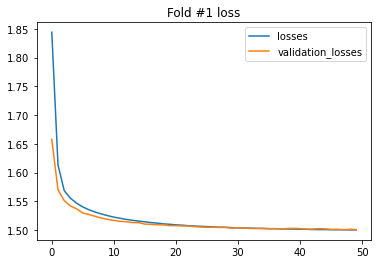

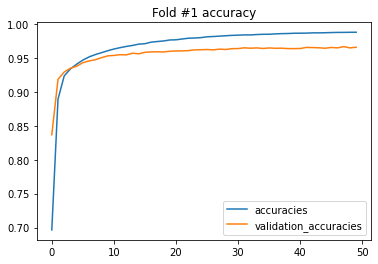

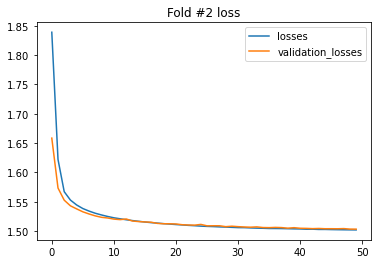

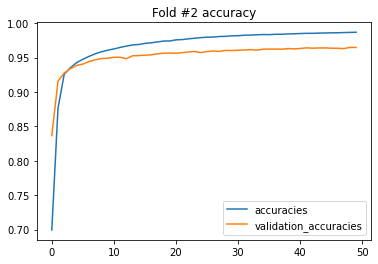

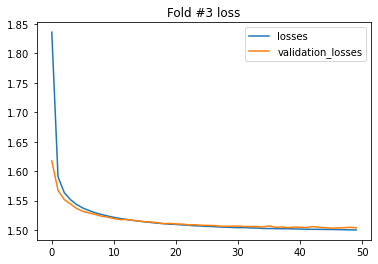

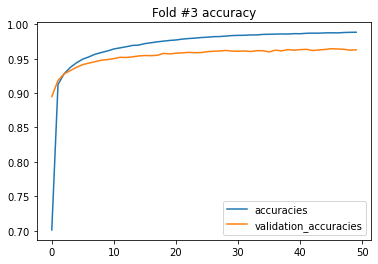

In [385]:
beastr = Kfold(MLPx,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=True,
          input_shape=(-1,1024))

### The gap between the validation and training losses is almost unnoticeable with L2 regularization, indicating that there is not overfitting. The model is at appropriate capacity and fits the data well. The training accuracy decreased and the test accuracy increased a little bit for this model compared to the model from 1d without regularization, so this model is definitely better overall.

### (c) (3pt) Use principal component analysis on the input, to create a reduced set of input features, keeping 99% of the variance. 

In [386]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
train_X=pca.fit_transform(train_X)
test_X = pca.transform(test_X)

In [387]:
class MLPp(nn.Module):
    def __init__(self):
        super(MLPp, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(331,50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        return self.layers(x)

modelp = MLPp()
p_total = sum(p.numel() for p in modelp.parameters())
modelx = MLPx()
x_total = sum(p.numel() for p in modelx.parameters())
print(x_total,p_total)

51760 17110


Fold #1


  2%|▏         | 1/50 [00:00<00:17,  2.85it/s]

Epoch 1/50 - Loss: 1.942 - Acc: 0.592
              Val_loss: 1.708 - Val_acc: 0.821


 22%|██▏       | 11/50 [00:03<00:13,  2.82it/s]

Epoch 11/50 - Loss: 1.513 - Acc: 0.958
              Val_loss: 1.528 - Val_acc: 0.941


 42%|████▏     | 21/50 [00:07<00:10,  2.79it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.973
              Val_loss: 1.518 - Val_acc: 0.946


 62%|██████▏   | 31/50 [00:11<00:06,  2.74it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.980
              Val_loss: 1.514 - Val_acc: 0.949


 82%|████████▏ | 41/50 [00:15<00:03,  2.60it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.983
              Val_loss: 1.512 - Val_acc: 0.951


func:'train'  took: 18.4002 sec
Train accuracy: 0.9844000000000012
Validation accuracy: 0.9515499999999996
Test accuracy: 0.9501000000000002
Fold #2


  2%|▏         | 1/50 [00:00<00:16,  2.88it/s]

Epoch 1/50 - Loss: 1.964 - Acc: 0.562
              Val_loss: 1.715 - Val_acc: 0.815


 22%|██▏       | 11/50 [00:03<00:13,  2.86it/s]

Epoch 11/50 - Loss: 1.513 - Acc: 0.958
              Val_loss: 1.531 - Val_acc: 0.937


 42%|████▏     | 21/50 [00:07<00:10,  2.84it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.973
              Val_loss: 1.521 - Val_acc: 0.945


 62%|██████▏   | 31/50 [00:10<00:06,  2.90it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.980
              Val_loss: 1.517 - Val_acc: 0.947


 82%|████████▏ | 41/50 [00:14<00:03,  2.70it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.983
              Val_loss: 1.515 - Val_acc: 0.948


func:'train'  took: 17.6642 sec
Train accuracy: 0.9851500000000009
Validation accuracy: 0.9480499999999998
Test accuracy: 0.9504
Fold #3


  2%|▏         | 1/50 [00:00<00:17,  2.76it/s]

Epoch 1/50 - Loss: 1.931 - Acc: 0.628
              Val_loss: 1.679 - Val_acc: 0.828


 22%|██▏       | 11/50 [00:03<00:13,  2.81it/s]

Epoch 11/50 - Loss: 1.514 - Acc: 0.957
              Val_loss: 1.529 - Val_acc: 0.939


 42%|████▏     | 21/50 [00:07<00:10,  2.85it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.973
              Val_loss: 1.519 - Val_acc: 0.947


 62%|██████▏   | 31/50 [00:10<00:06,  2.77it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.980
              Val_loss: 1.514 - Val_acc: 0.950


 82%|████████▏ | 41/50 [00:14<00:03,  2.83it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.983
              Val_loss: 1.512 - Val_acc: 0.952


func:'train'  took: 17.7551 sec
Train accuracy: 0.9843250000000011
Validation accuracy: 0.9522999999999996
Test accuracy: 0.9524000000000001
Final results:
Training accuracy:0.984625+-0.000372
Testing accuracy:0.950967+-0.001021


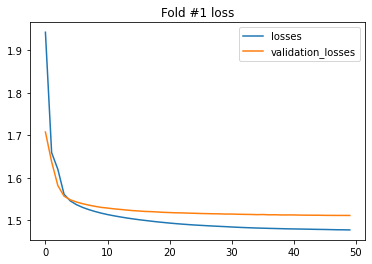

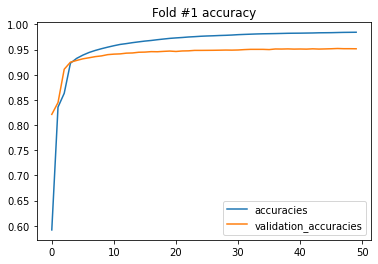

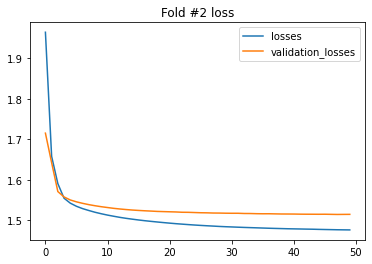

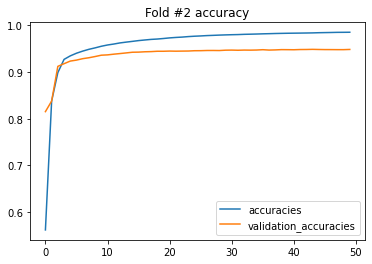

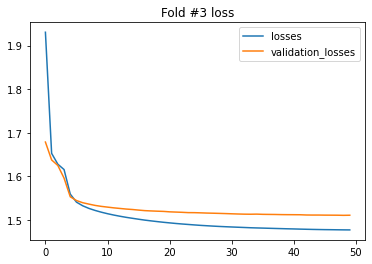

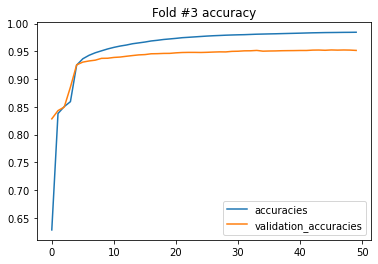

In [388]:
beastp = Kfold(MLPp,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=False,
          input_shape=(-1,331))

### This model had 17,110 parameters, whereas the original model from 1d has 51,760. The training and test accuracies were both lower for this model compared to the one from 1d (still good accuracies at 98.5% and 95% respectively), but the model took almost half as much time to train because it had less parameters compared to the original. The gap between validation and training losses increases similarly on the curves for this model as it did for 1d, indicating that this model also overfits the data by what would seem like a rougly similar amount.

Fold #1


  2%|▏         | 1/50 [00:00<00:25,  1.95it/s]

Epoch 1/50 - Loss: 1.968 - Acc: 0.558
              Val_loss: 1.749 - Val_acc: 0.744


 22%|██▏       | 11/50 [00:05<00:17,  2.26it/s]

Epoch 11/50 - Loss: 1.530 - Acc: 0.955
              Val_loss: 1.531 - Val_acc: 0.938


 42%|████▏     | 21/50 [00:09<00:12,  2.35it/s]

Epoch 21/50 - Loss: 1.517 - Acc: 0.969
              Val_loss: 1.520 - Val_acc: 0.948


 62%|██████▏   | 31/50 [00:13<00:08,  2.35it/s]

Epoch 31/50 - Loss: 1.511 - Acc: 0.977
              Val_loss: 1.514 - Val_acc: 0.954


 82%|████████▏ | 41/50 [00:17<00:03,  2.48it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.981
              Val_loss: 1.511 - Val_acc: 0.957


func:'train'  took: 21.3604 sec
Train accuracy: 0.9835750000000013
Validation accuracy: 0.959049999999999
Test accuracy: 0.9594000000000005
Fold #2


  2%|▏         | 1/50 [00:00<00:22,  2.18it/s]

Epoch 1/50 - Loss: 1.936 - Acc: 0.603
              Val_loss: 1.679 - Val_acc: 0.827


 22%|██▏       | 11/50 [00:05<00:19,  2.02it/s]

Epoch 11/50 - Loss: 1.530 - Acc: 0.955
              Val_loss: 1.532 - Val_acc: 0.939


 42%|████▏     | 21/50 [00:10<00:12,  2.33it/s]

Epoch 21/50 - Loss: 1.517 - Acc: 0.969
              Val_loss: 1.520 - Val_acc: 0.949


 62%|██████▏   | 31/50 [00:14<00:08,  2.19it/s]

Epoch 31/50 - Loss: 1.511 - Acc: 0.977
              Val_loss: 1.516 - Val_acc: 0.952


 82%|████████▏ | 41/50 [00:18<00:03,  2.42it/s]

Epoch 41/50 - Loss: 1.508 - Acc: 0.981
              Val_loss: 1.513 - Val_acc: 0.954


func:'train'  took: 22.5289 sec
Train accuracy: 0.9841000000000005
Validation accuracy: 0.9566499999999991
Test accuracy: 0.9612000000000006
Fold #3


  2%|▏         | 1/50 [00:00<00:21,  2.32it/s]

Epoch 1/50 - Loss: 1.947 - Acc: 0.601
              Val_loss: 1.687 - Val_acc: 0.825


 22%|██▏       | 11/50 [00:04<00:16,  2.41it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.956
              Val_loss: 1.528 - Val_acc: 0.942


 42%|████▏     | 21/50 [00:08<00:11,  2.44it/s]

Epoch 21/50 - Loss: 1.516 - Acc: 0.971
              Val_loss: 1.517 - Val_acc: 0.950


 62%|██████▏   | 31/50 [00:13<00:08,  2.37it/s]

Epoch 31/50 - Loss: 1.510 - Acc: 0.979
              Val_loss: 1.512 - Val_acc: 0.956


 82%|████████▏ | 41/50 [00:17<00:04,  2.11it/s]

Epoch 41/50 - Loss: 1.506 - Acc: 0.983
              Val_loss: 1.509 - Val_acc: 0.959


func:'train'  took: 21.8316 sec
Train accuracy: 0.9849500000000004
Validation accuracy: 0.960149999999999
Test accuracy: 0.9639000000000002
Final results:
Training accuracy:0.984208+-0.000567
Testing accuracy:0.961500+-0.001849


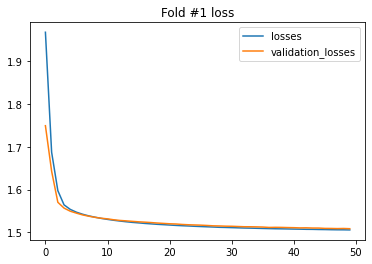

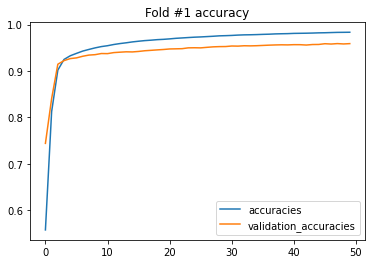

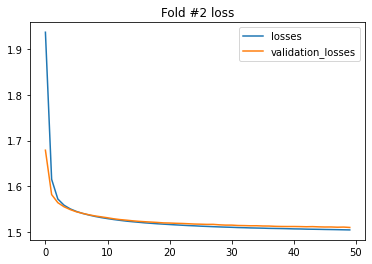

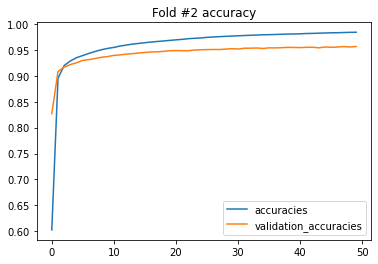

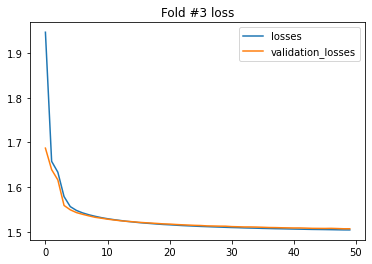

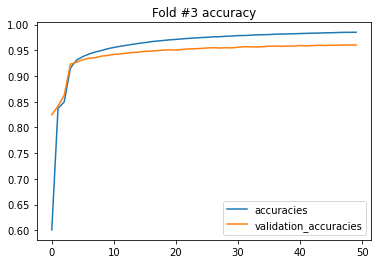

In [389]:
beastp = Kfold(MLPp,3,train_X,train_y,test_X,test_y,50,draw_curve=True,early_stop=True,batchsize=128, optimizer='adam',lr=2e-3,l2=True,
          input_shape=(-1,331))

### I chose to include l2 regularization because it seemed to improve the model for 2b whereas dropout did not seem to do anything. The gap between the validation and training losses has vanished (due to l2 regularization), indicating that this model does not overfit the data. It also ran comparatively faster than the model from 1d (due to PCA) and the test accuracy is almost exactly the same as it is for the model from 1d. So overall, this model is better as it fits the data better and runs faster.